data analysis libraries

In [112]:
# data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
#plot align
%matplotlib inline 
#show DFs
pd.set_option('display.max_rows', 100)
pd.set_option('display.width',1000)
#plot style
plt.style.use('dark_background')
import sys
sys.path.append('../utils')
sys.path.append('../project_files')
import functions_cali_homes_model as cf


import california housing

In [113]:
# sikit learn data --> from sklearn.datasets import fetch_california_housing

cali_df=pd.read_csv('../project_files/sklearn_cali_housing.csv')

store a copy

In [114]:
untouched_df=cali_df.copy()

In [115]:
cali_df.dropna(inplace=True)

cap outliers

In [116]:
#replace outliers with np.nan

#maximum value limits 
to_cap={'AveOccup':15,
        'Population':7500,
        'AveBedrms':4,
        'AveRooms':10,
        'MedInc':10,}

cali_df=cf.cap_max_w_nan(cali_df,to_cap)

In [117]:
cali_df.isnull().sum()

MedInc        308
HouseAge        0
AveRooms      226
AveBedrms      67
Population     81
AveOccup       19
Latitude        0
Longitude       0
Target          0
dtype: int64

fill the NaN values based on similar observations

In [118]:
# fill nan function that considers surrounding rows

most_important_features=['Target','MedInc']
dataframe=cali_df
window_size=16
cali_df=cf.neighbor_fillna(most_important_features,dataframe,window_size)

cali_df.isnull().sum()  

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Target        0
dtype: int64

### a look at distributions after treating outliers

9 Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Target'], dtype='object')


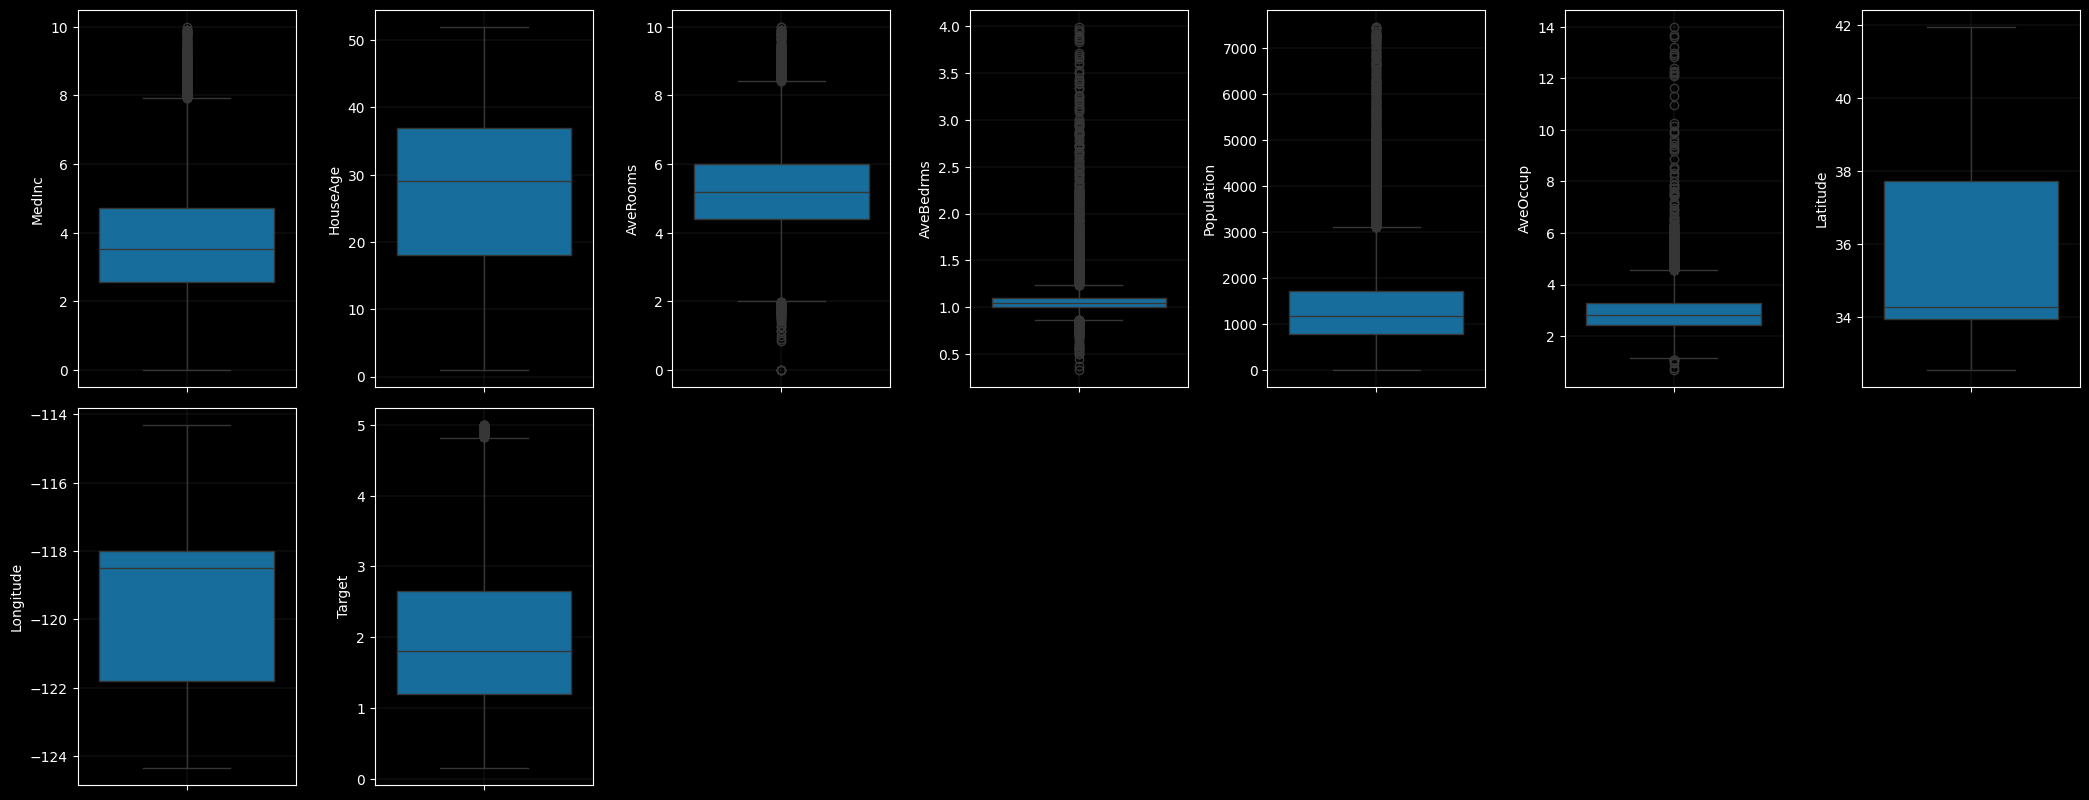

In [119]:

headers=cali_df.columns
print(len(headers),headers)
col=7
n=len(headers)
row=n//2 if n%2==0 else (n//2)+1
fig=plt.rcParams['figure.figsize']=(col*3,row*4)
for i in range(1,n+1):
    plt.subplot(row,col,i)
    h=headers[i-1]
    sns.boxplot(cali_df[h],palette='colorblind')
    plt.grid(linewidth=.075,color='lightgrey')
plt.tight_layout()
plt.show()
    

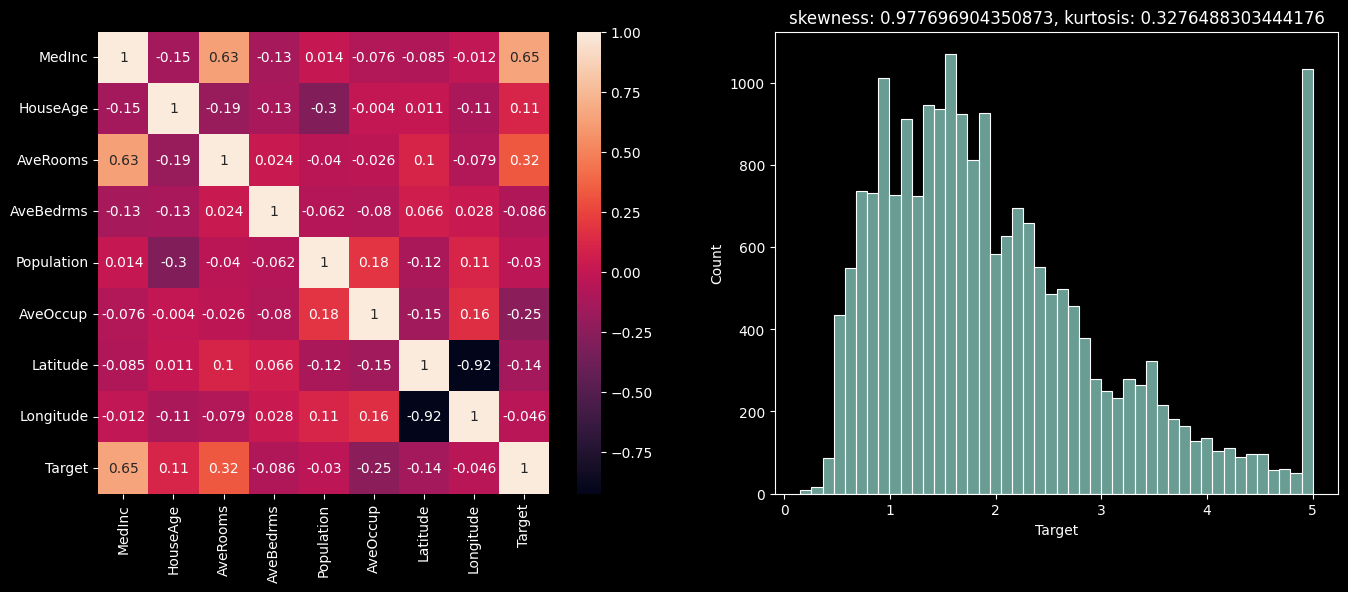

In [120]:
rows=1
columns=2
fig= plt.figure(figsize=(columns*8,rows*6))
plt.subplot(rows,columns,1)
sns.heatmap(cali_df.corr(),annot=True)
plt.subplot(rows,columns,2)
sns.histplot(cali_df['Target'])
skw=cali_df['Target'].skew()
krt=cali_df['Target'].kurt()
plt.title(f'skewness: {skw}, kurtosis: {krt}')
plt.show()

# Latitude and Longitude

Text(0.5, 1.0, 'Image source: Bing Images. Used under fair use for educational purposes only')

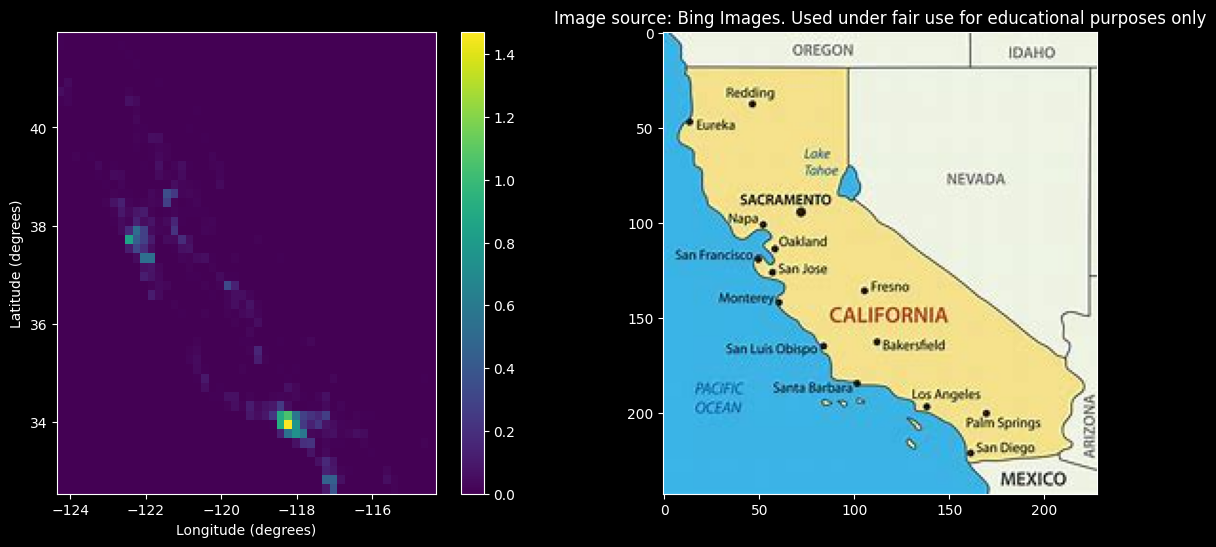

In [121]:
# NOTE: this image is used for educational purposes only
img = plt.imread("../utils/cali_img.jfif")
latitude = cali_df['Latitude'].to_numpy()
longitude = cali_df['Longitude'].to_numpy()
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
hist = ax[0].hist2d(longitude, latitude, bins=50, density=True)#color='grey',,cmap='Wistia'
ax[0].set_aspect(1.3, "box")
fig.colorbar(hist[3])
ax[0].set_xlabel("Longitude (degrees)")
ax[0].set_ylabel("Latitude (degrees)")
plt.subplot(1,2,2)
plt.imshow(img)
plt.title('Image source: Bing Images. Used under fair use for educational purposes only')


# Create a Feature based on Region

a look at latitude and longitude distributions with special attention to spread and/or dispersion

latitude range:  313.0
longitude range:  334.0


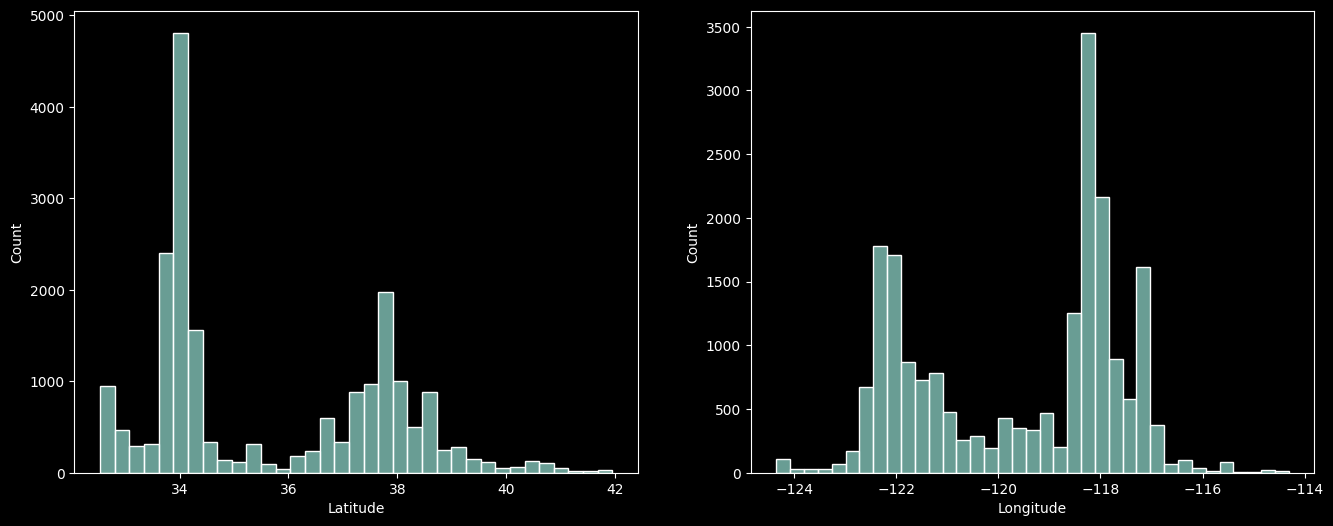

In [122]:
#  0.01 represents 69.17 miles

latmn=cali_df['Latitude'].min()
latmx=cali_df['Latitude'].max()
lonmn=cali_df['Longitude'].min()
lonmx=cali_df['Longitude'].max()
cali_df['Latitude'].unique()
cali_df['Longitude'].unique()
n=0.03                                  #bins of size 207.51 square miles
print('latitude range: ',(latmx-latmn)//n)               #spread
print('longitude range: ',(lonmx-lonmn)//n)                #spread
fig=plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(cali_df['Latitude'])
plt.subplot(1,2,2)
sns.histplot(cali_df['Longitude'])
plt.show()

Latitude and Longitude bins

In [123]:
cali_df=cf.get_bins(cali_df,'Latitude',edge_size=0.03)
cali_df=cf.get_bins(cali_df,'Longitude',edge_size=0.03)

## now there are bins for latitude and longitude respectively  


Text(0.5, 1.0, 'Image source: Bing Images. Used under fair use for educational purposes only')

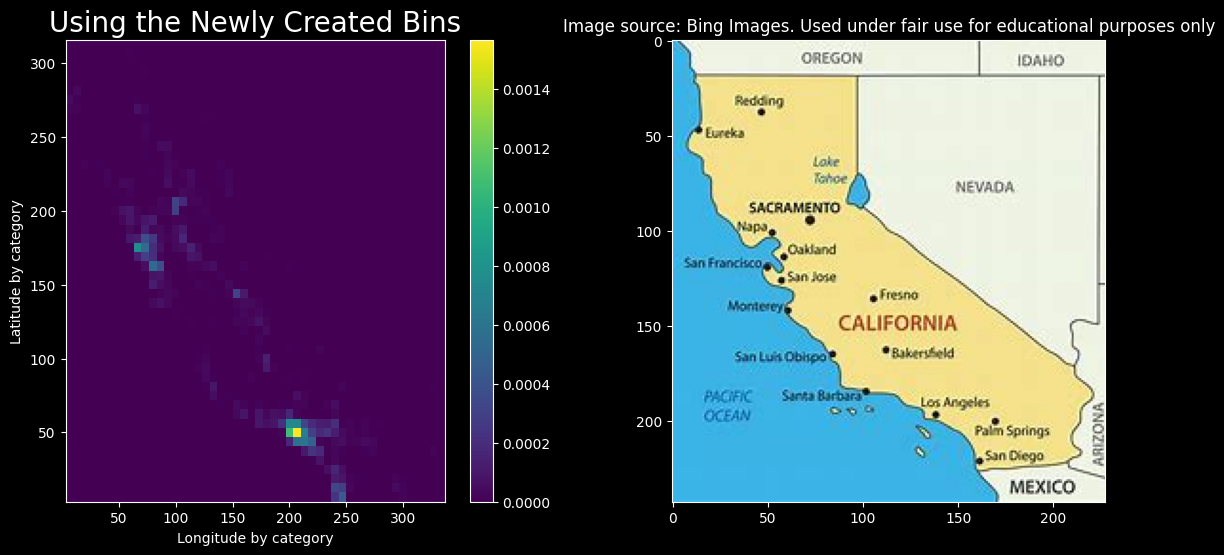

In [124]:
# NOTE: this image is used for educational purposes only
img = plt.imread("../utils/cali_img.jfif")
latitude = cali_df['Latitude_category'].to_numpy()
longitude = cali_df['Longitude_category'].to_numpy()
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
hist = ax[0].hist2d(longitude, latitude, bins=50, density=True)#color='grey',,cmap='Wistia'
ax[0].set_aspect(1.3, "box")
fig.colorbar(hist[3])
ax[0].set_xlabel("Longitude by category")
ax[0].set_ylabel("Latitude by category")
ax[0].set_title("Using the Newly Created Bins",fontsize=20)
plt.subplot(1,2,2)
plt.imshow(img)
plt.title('Image source: Bing Images. Used under fair use for educational purposes only')


add an ordinal region column according to home prices in each latitude-longitude bin   

 >'Region' 

In [125]:
dcm=2   # specifies how many decimal places the location variable will have
llc=cali_df.groupby(['Latitude_binned','Longitude_binned'],as_index=False)['Target'].mean().rename(columns={'Target':'Mean_Target'})
llc=llc.sort_values(by='Mean_Target',ascending=True,inplace=False).reset_index(drop=True)
llc['Region']=llc['Mean_Target'].apply(lambda x: round(x,dcm))
print(f'There are {len(llc['Region'].unique())} unique Location_variables.')

There are 455 unique Location_variables.


fit the Location_variable to each observation

In [126]:
llc.sort_values(by=['Latitude_binned','Longitude_binned'],inplace=True)
lookup_key=list(zip(llc['Latitude_binned'],llc['Longitude_binned']))
lookup_items=dict(zip(lookup_key,llc['Region']))
lookup_list=list(zip(lookup_key,llc['Region']))          #This is what is loaded into the pickle file. Hence it is not mapped
cali_df['Region']=cali_df[['Latitude_binned','Longitude_binned']].apply(lambda x: lookup_items.get((x['Latitude_binned'],x['Longitude_binned']),np.nan),axis=1)
cali_df[['Region','Latitude_binned','Longitude_binned']].iloc[::3000,:]

,Region,Latitude_binned,Longitude_binned
0,0.15,"(40.28000000000029, 40.310000000000294)","(-123.17999999999995, -123.14999999999995)"
3000,0.99,"(36.74000000000016, 36.77000000000016)","(-119.69999999999982, -119.66999999999982)"
6000,1.16,"(37.970000000000205, 38.000000000000206)","(-122.36999999999992, -122.33999999999992)"
9000,1.67,"(39.23000000000025, 39.260000000000254)","(-120.08999999999983, -120.05999999999983)"
12000,2.02,"(39.050000000000246, 39.08000000000025)","(-121.04999999999987, -121.01999999999987)"
15000,2.21,"(37.7600000000002, 37.7900000000002)","(-122.27999999999992, -122.24999999999991)"
18000,4.33,"(34.040000000000056, 34.07000000000006)","(-118.46999999999977, -118.43999999999977)"


store the variable and its key in a .pkl

In [127]:
import pickle

data = lookup_list

#save the data
with open("../utils/Cali_Housing_LatMinLatMax_LongMinLongMax_key.pkl", "wb") as f:
    pickle.dump(data, f)

#load the data
with open("../utils/Cali_Housing_LatMinLatMax_LongMinLongMax_key.pkl", "rb") as f:
    loaded_data = pickle.load(f)

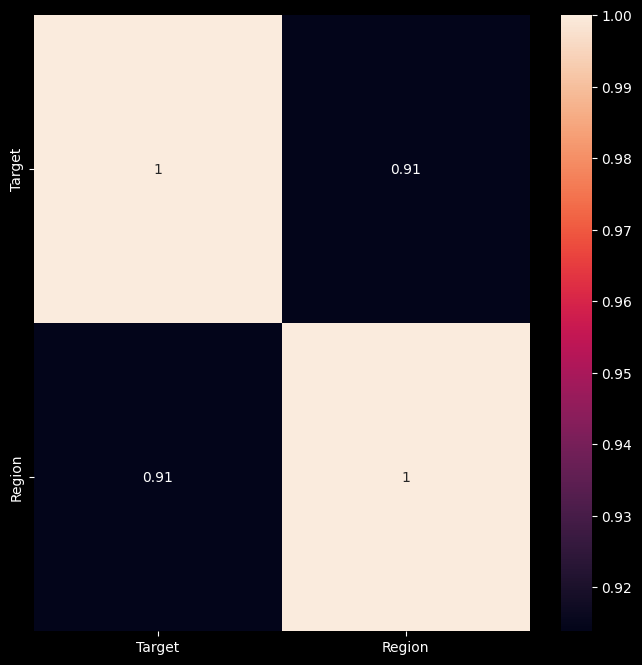

In [128]:
correlation_matrix=cali_df[['Target','Region']]
correlation_matrix=correlation_matrix.corr()
fig=plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
sns.heatmap(correlation_matrix,annot=True)
plt.show()

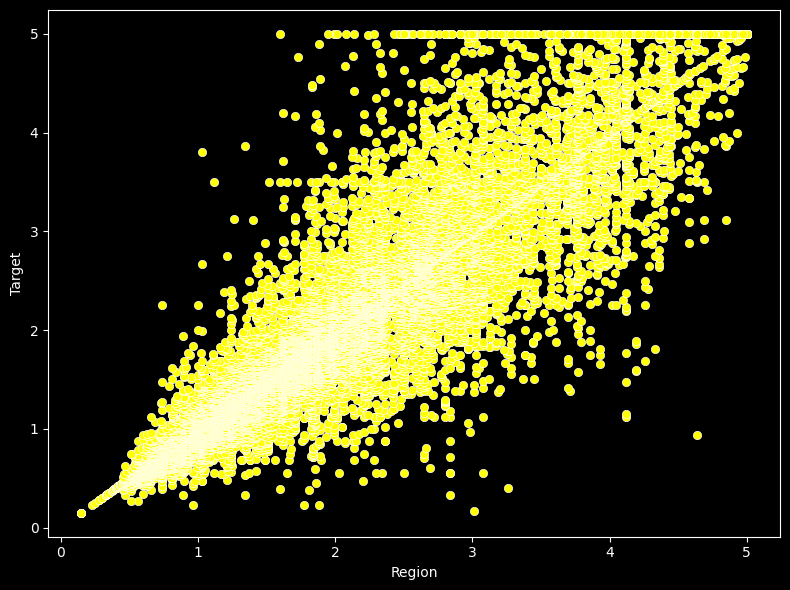

In [129]:
independent_vars=['Region']
dependant_var='Target'
cols=1
rows=len(independent_vars)//cols if len(independent_vars)%cols==0 else(len(independent_vars)//cols)+1

fig=plt.figure(figsize=(cols*8,rows*6))
for _ in range(1,(rows*cols)+1):
    if _ < 3:
        plt.subplot(rows,cols,_)
        x=independent_vars[_-1]
        sns.scatterplot(data=cali_df,x=x,y=dependant_var,color='yellow')
        plt.xlabel(independent_vars[_-1])
        plt.ylabel(dependant_var)
    else:
        plt.subplot(rows,cols,_)
        x=cali_df[independent_vars[(_//2)-1]]
        skw=x.skew()
        krt=x.kurt()
        sns.histplot(x,bins=100)
        plt.xlabel(independent_vars[(_//2)-1])
        plt.title(f'kurtosis: {krt}, skewness: {skw}')
plt.tight_layout()
plt.show()          

# Create a Linear Regression Model 

In [130]:
#drop 1 row where there is a 0 in order to prepare for log transformation
print(cali_df.shape)
cali_df=cali_df.loc[(cali_df!=0).all(axis=1)]
print(cali_df.shape)


(20640, 14)
(20633, 14)


choose features

In [131]:
#['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Longitude_category',  'Latitude_category', 'Region']


features=['Region', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',  'MedInc']

In [132]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log)

df1=log_transformer.transform(cali_df[features+['Target']])


X=df1[features]
y=df1['Target']

In [133]:
from sklearn.model_selection import train_test_split 

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=.25,random_state=53)

In [134]:
#model selection and cross validation

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet



alpha=.0000085

model=Lasso(alpha=alpha) 
cv_score=cross_val_score(model,x_train,y_train,cv=6,scoring='r2')
    

In [135]:
print(f'alpha: {i} ','mean: ',cv_score.mean(),'cv: ',cv_score)

alpha: 9  mean:  0.8882420074880536 cv:  [0.89354803 0.88871065 0.88946366 0.89009756 0.87733267 0.89029948]


In [136]:
model.fit(x_train,y_train)

Lasso(alpha=8.5e-06)

evaluate on training data

In [137]:
from sklearn.metrics import r2_score
train_hat=model.predict(x_train)
train_score=r2_score(y_train,train_hat)
train_score

0.8884458019378818

evaluate on unseen test data

In [138]:
test_hat=model.predict(x_test)
test_score=r2_score(y_test,test_hat)
test_score

0.8851790463043293

In [139]:
slope=model.coef_
features=x_train.columns
intercept=model.intercept_
coefficients={features[i]:slope[i] for i in range(len(slope))}
coefficients['intercept']=intercept
coefficients['train_r2']=r2_score(y_train,train_hat)
coefficients['test_r2']=r2_score(y_test,test_hat)
grand_hat=model.predict(X)
coefficients['grand_r2']=r2_score(y,grand_hat)
coefficients


{'Region': 0.8935104332595226,
 'HouseAge': 0.019142823279991422,
 'AveRooms': 0.08880735297600134,
 'AveBedrms': -0.014203403967603405,
 'Population': -0.001826275941154776,
 'AveOccup': -0.06401278331209824,
 'MedInc': 0.17019346000488064,
 'intercept': -0.2916778874667836,
 'train_r2': 0.8884458019378818,
 'test_r2': 0.8851790463043293,
 'grand_r2': 0.887623431759065}

# r2 score after transforming data back to its original scale:

In [140]:
df2 = log_transformer.transform(cali_df[list(features)+['Target']])
df2_columns = df2.columns
cols_to_use2 = [i for i in coefficients.keys() if i in df2_columns]+['Target']
df2['Predicted_Value'] = df2.apply(lambda row: sum(coefficients[i]*row[i] for i in cols_to_use2 if i !='Target') + coefficients['intercept'], axis=1)
df2=np.exp(df2)
r2=r2_score(df2['Target'],df2['Predicted_Value'])
r2

0.8577951248678068

# Evaluate the same model, but without treating outliers

### functions for accessing the location identifiers column  

In [141]:
#apply the function
untouched_df['Region']=untouched_df[['Latitude','Longitude']].apply(lambda row: cf.get_region(row['Latitude'],row['Longitude'],loaded_data),axis=1)
untouched_df.iloc[::3500,:]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target,Region
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,4.46
3500,4.8015,30.0,5.549296,0.992958,1004.0,3.535211,34.27,-118.46,1.797,1.71
7000,3.3214,42.0,4.454829,1.052960,1269.0,3.953271,33.96,-118.04,1.488,2.00
10500,3.8600,23.0,5.518927,1.138801,1480.0,2.334385,33.47,-117.69,3.000,3.18
14000,3.5507,4.0,7.327988,1.161808,1869.0,2.724490,34.59,-117.24,1.861,1.86
17500,5.1615,26.0,6.687037,1.042593,2089.0,3.868519,34.43,-119.79,2.762,2.74


In [142]:
#drop null 

untouched_df=untouched_df.loc[(untouched_df!=0).all(axis=1)]

untouched_df.dropna(inplace=True)

transform the data with log and apply the model  
Then transform data back with exp  
Then get the r2  

In [143]:
df3 = untouched_df
df3_columns = df3.columns
cols_to_use3 = [i for i in coefficients.keys() if i in df3_columns]+['Target']

df3 = log_transformer.transform(df3[cols_to_use3])
df3['Predicted_Value'] = np.exp(df3.apply(lambda row: sum(coefficients[i]*row[i] for i in cols_to_use3 if i !='Target') + coefficients['intercept'], axis=1))

df3['Target'] = np.exp(df3['Target'])

r2=r2_score(df3['Target'],df3['Predicted_Value'])
r2

0.8611502807068141